### Import basic libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Load in the dataframe

In [9]:
df = pd.read_pickle('./main_df.pkl')
print(df.shape)
df.head()

(2213180, 12)


,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,y
0,NC_010363,NC_008527,60.8,0.0,0.021973,0.0,0.002122,0.398421,0.382144,0.0,-1.33553,1
1,NC_010363,NC_002662,59.0,0.0,0.016709,0.0,0.001929,0.397773,0.377498,0.0,-1.33035,1
2,NC_010363,NC_017949,59.0,0.0,0.020818,0.0,0.002088,0.396969,0.379686,0.0,-1.33341,1
3,NC_010363,NC_017492,59.0,0.0,0.022209,0.0,0.002131,0.396148,0.380930,0.0,-1.33767,1
4,NC_010363,NC_009004,59.0,0.0,0.020871,0.0,0.002088,0.397095,0.379834,0.0,-1.33341,1


## Data preprocessing

### Get all of positive cases + the same number of negative cases randomly

In [10]:
# get all the positive cases
learning_df = df[df['y'] == 1]
# get the same amount of negative cases RANDOMLY
negative_learning_df = df[df['y'] == 0].sample(n=len(df[df['y'] == 1].index))

learning_df = learning_df.append(negative_learning_df)
print(learning_df.shape)
learning_df.head()

(33514, 12)


,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,y
0,NC_010363,NC_008527,60.8,0.0,0.021973,0.0,0.002122,0.398421,0.382144,0.0,-1.33553,1
1,NC_010363,NC_002662,59.0,0.0,0.016709,0.0,0.001929,0.397773,0.377498,0.0,-1.33035,1
2,NC_010363,NC_017949,59.0,0.0,0.020818,0.0,0.002088,0.396969,0.379686,0.0,-1.33341,1
3,NC_010363,NC_017492,59.0,0.0,0.022209,0.0,0.002131,0.396148,0.380930,0.0,-1.33767,1
4,NC_010363,NC_009004,59.0,0.0,0.020871,0.0,0.002088,0.397095,0.379834,0.0,-1.33341,1


### Encode categorical values

*Note: encoding not needed because training is not based on virus and host names*

In [ ]:
'''
transformed_data = pd.get_dummies(filled_df, columns=['virus', 'host'])
transformed_data
'''

### Extract X and y arrays

In [12]:
X = learning_df.drop(['virus', 'host', 'y'], axis=1).values
y = learning_df['y'].values

print(f'shape of X: {X.shape}')
print(f'len(y): {len(y)}')

len(y): 33514
shape of X: (33514, 9)


### test_train_split

In [30]:
# SIMPLE SPLIT
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Feature scaling (if necessary) 

### Train the Random Forst Classifier

In [14]:
# ONLY FOR SIMPLE SPLIT USE
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

### Predict Test set results

In [15]:
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 0]
 [0 0]
 [0 0]
 ...
 [1 1]
 [1 1]
 [0 0]]


## Score the model

### Confusion Matrix

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[4039   95]
 [ 141 4104]]


0.9718343477741974

### ROC curve

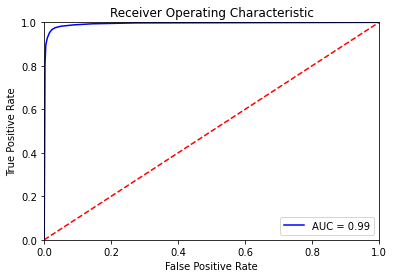

In [17]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = classifier.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

*Note: conclusion: ROC curve is a bad method to evaluate this kind of data*

## F1 score

In [19]:
print(cm)
accuracy_score(y_test, y_pred)

[[4039   95]
 [ 141 4104]]


0.9718343477741974

### Calculate precision and recall

In [20]:
from sklearn.metrics import precision_score, recall_score
print('Precision is: ', precision_score(y_test, y_pred))
print('Recall is: ', recall_score(y_test, y_pred))

Precision is:  0.9773755656108597
Recall is:  0.9667844522968198


### F1 score for this model 

In [21]:
from sklearn.metrics import f1_score
print(f'F1 is: {f1_score(y_test, y_pred)}')

F1 is: 0.9720511605873993


*Note: the model still has a very good score*

*Ideas as to why:* 
1. *Now there is enough data to train the model - ca. 16,5k positive cases + 16,5k randomly chosen negative ones*
    * _to get learning_df closer to natural, a different method (learning for unbalanced set - ___stratified sampling___) will probably be needed_ 
2. *Still huge host and phage in-group similarity (hosts often with only a few nucleotide difference in genome) - not adressed!* 
3. *Randomly chosen 'good' negative cases?*

# Training using cross validation

In [ ]:
# Leave one out split
from sklearn.model_selection import LeaveOneOut
cv = LeaveOneOut()

Explicit tqdm handling (better visualisaition)

*Watch out -* ***long!***

In [ ]:
'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm
# enumerate splits
y_true, y_pred = list(), list()
pbar = tqdm(total=len(X))

for train_ix, test_ix in cv.split(X):
    # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    # fit model
    model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=1)
    model.fit(X_train, y_train)
    # evaluate model
    yhat = model.predict(X_test)
    # store
    y_true.append(y_test[0])
    y_pred.append(yhat[0])
    pbar.update(1)
pbar.close()
# calculate accuracy
acc = accuracy_score(y_true, y_pred)
print(f'Accuracy: {acc:.3f}')
'''

Using cross_val_score function

*Watch out -* ***long and hard to stop!***

In [ ]:
'''
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
# create loocv procedure
cv = LeaveOneOut()
# create model
model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print(f'Accuracy: {np.mean(scores):.3f} ({np.std(scores):.3f})')
'''